In [14]:
pip install prophet openpyxl seaborn scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --------------------------- ------------ 6.0/8.7 MB 33.5 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 31.8 MB/s  0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   -------- ------------------------------- 7.9/38.6 MB 37.4 MB/s eta 0:00:01
   ------------------- -------------------- 18.4/38.6 MB 42.9 MB/s eta 0:00:01
   ---------------------------- ----------- 27.3/38.6 MB 44.3 MB/s eta 0:00:01
   -------------------------------------- - 36.7/38.6 MB 44.0 MB/s eta 0:00:01
   ---------------------------------------- 38.6/38.6 MB 40.2 MB/s  0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ---------

In [119]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import date
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

In [2]:
# foucsing on south region
df = pd.read_excel('Weather_aggregated.xlsx', sheet_name='South')
df

,calendar_week_year,Week,Year,MinSurfaceTemperatureFahrenheit,MaxSurfaceTemperatureFahrenheit,AvgSurfaceTemperatureFahrenheit,MinRelativeHumidityPercent,MaxRelativeHumidityPercent,AvgRelativeHumidityPercent,MinPrecipitationPreviousHourInches,MaxPrecipitationPreviousHourInches,AvgPrecipitationPreviousHourInches,SumPrecipitationPreviousHourInches,MinZeroToTenLiquidSoilMoisturePercent,MaxZeroToTenLiquidSoilMoisturePercent,AvgZeroToTenLiquidSoilMoisturePercent
0,2019/1,1,2019,46.233333,59.500000,51.283333,77.000000,96.333333,90.666667,0.001667,0.073500,0.018500,0.438333,38.850000,40.716667,39.566667
1,2019/2,2,2019,41.328571,59.542857,48.328571,61.428571,90.571429,79.285714,0.000000,0.015714,0.003143,0.068571,36.771429,37.828571,37.271429
2,2019/3,3,2019,39.985714,51.614286,45.442857,74.428571,94.285714,86.285714,0.000000,0.046143,0.006286,0.162857,36.485714,37.757143,36.971429
3,2019/4,4,2019,33.814286,53.857143,42.085714,58.285714,90.428571,78.285714,0.000143,0.058714,0.010000,0.242857,36.214286,38.500000,37.400000
4,2019/5,5,2019,38.085714,58.971429,45.814286,54.000000,89.000000,75.000000,0.000000,0.026143,0.002857,0.080143,35.900000,37.085714,36.542857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2021/48,48,2021,50.900000,70.042857,58.157143,55.857143,95.571429,82.285714,0.000000,0.001857,0.000143,0.008714,30.971429,31.628571,31.357143
153,2021/49,49,2021,46.628571,62.471429,55.057143,73.285714,94.714286,87.142857,0.000000,0.064429,0.010143,0.271429,33.600000,36.371429,34.400000
154,2021/50,50,2021,53.100000,69.328571,58.885714,72.571429,97.714286,89.142857,0.000000,0.015857,0.003000,0.077143,32.914286,34.014286,33.485714
155,2021/51,51,2021,47.100000,61.871429,52.328571,66.000000,93.285714,83.285714,0.000000,0.008857,0.001571,0.034286,32.942857,33.814286,33.371429


Text(0, 0.5, 'Value (Units)')

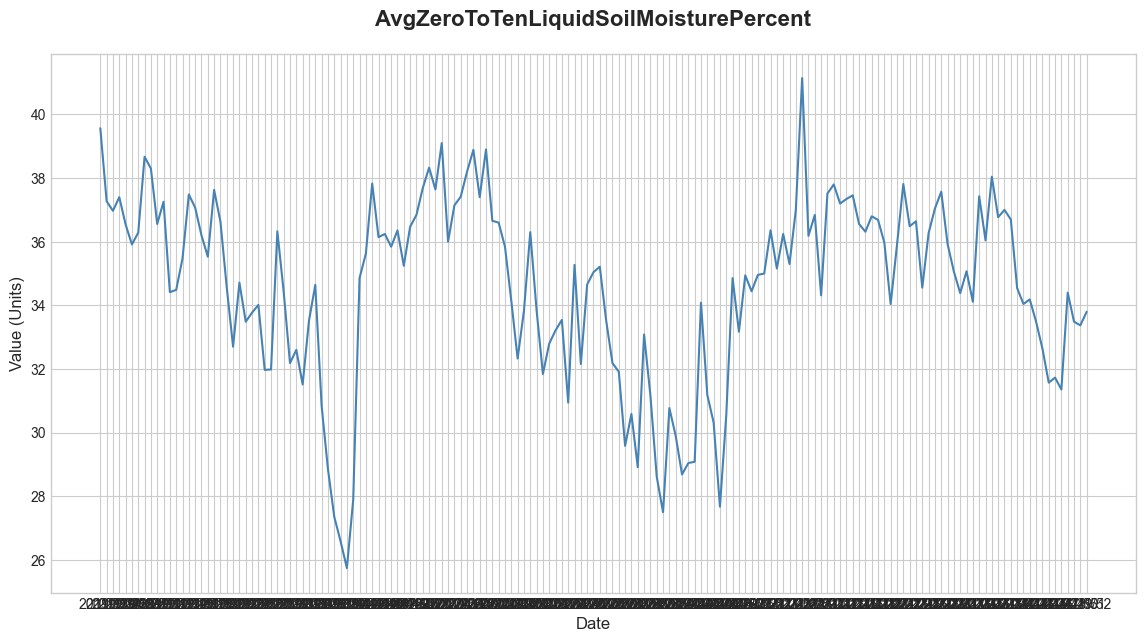

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
plt.plot(df['calendar_week_year'], df['AvgZeroToTenLiquidSoilMoisturePercent'], color='steelblue', linewidth=1.5, label='AvgZeroToTenLiquidSoilMoisturePercent')
plt.title('AvgZeroToTenLiquidSoilMoisturePercent', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value (Units)', fontsize=12)

In [4]:
df_POS = pd.read_excel('Big 3 - Yearly Category POS 2018-2022q1.xlsx', sheet_name='POS Sales')
split_data = df_POS['Calendar_year_week'].str.split('/', expand=True)
df_POS['Week'] = split_data[0].astype(int)
df_POS['Year'] = split_data[1].astype(int)

condition_product = (df_POS['Category'] == 'LAWN FERTILIZERS')
condition_region = (df_POS['Region'] == 'SOUTH')

SOUTH_LF = df_POS[condition_product & condition_region]

In [5]:
SOUTH_LF

,Region,Category,Calendar_year_week,Dollars,Units,Week,Year
0,SOUTH,LAWN FERTILIZERS,01/2018,191596.61,7866.0,1,2018
1,SOUTH,LAWN FERTILIZERS,02/2018,362923.18,14956.0,2,2018
2,SOUTH,LAWN FERTILIZERS,03/2018,366936.44,15045.0,3,2018
3,SOUTH,LAWN FERTILIZERS,04/2018,749092.90,29596.0,4,2018
4,SOUTH,LAWN FERTILIZERS,05/2018,1027500.25,38700.0,5,2018
...,...,...,...,...,...,...,...
11003,SOUTH,LAWN FERTILIZERS,10/2022,7076973.85,169106.0,10,2022
11004,SOUTH,LAWN FERTILIZERS,11/2022,12347281.22,293639.0,11,2022
11005,SOUTH,LAWN FERTILIZERS,12/2022,11411697.00,282820.0,12,2022
11006,SOUTH,LAWN FERTILIZERS,13/2022,11957080.95,304712.0,13,2022


Text(0, 0.5, 'Value (Units)')

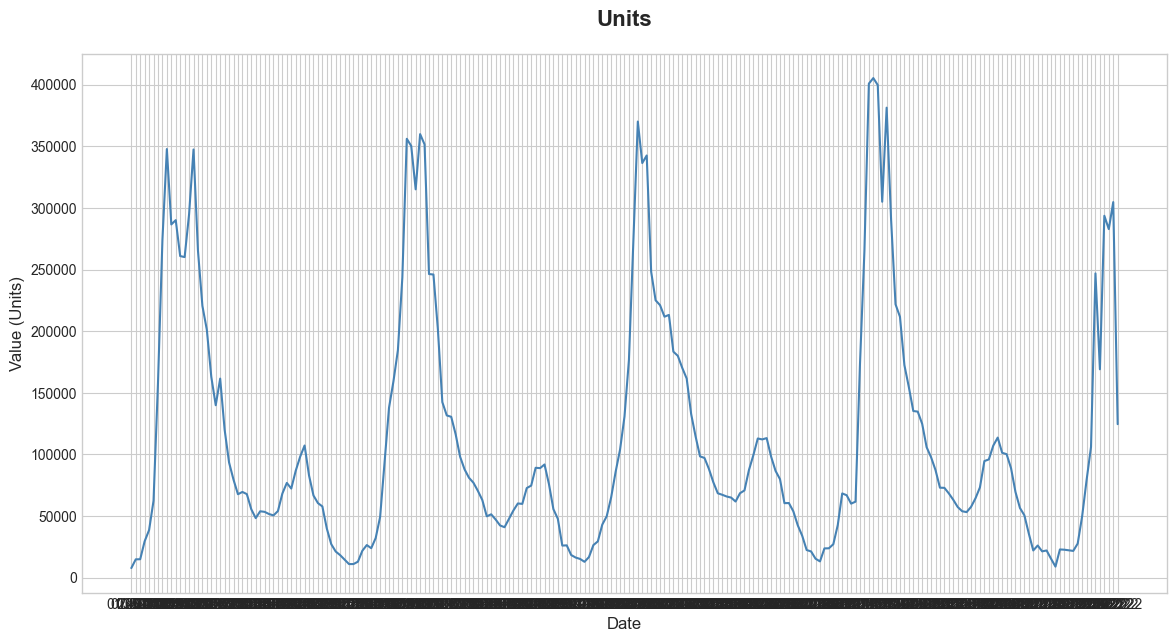

In [6]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
plt.plot(SOUTH_LF['Calendar_year_week'], SOUTH_LF['Units'], color='steelblue', linewidth=1.5, label='Units')
plt.title('Units', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value (Units)', fontsize=12)

* It is completely evident from visual inspection that there is a strong seasonal component occuring with a yearly period.
* The trend seems to be quite flat.
* The peak or amplitude at the very end seems to be smaller than previous years indicating advent of something during that time.

<Axes: >

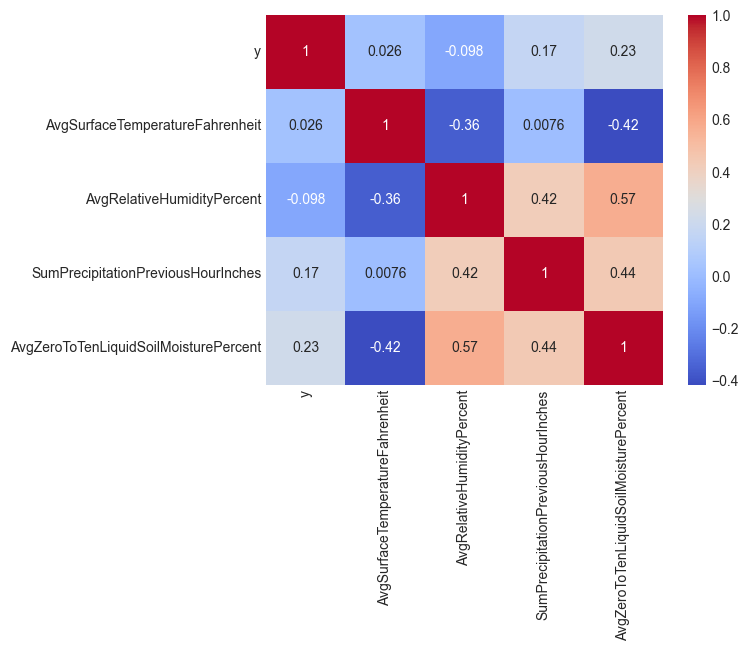

In [7]:
# let's check for any correlation between sales and weather
join_keys = ['Week', 'Year']
df_inner_join = pd.merge(
    SOUTH_LF, 
    df, 
    on=join_keys, 
    how='inner'
) 
# Feature engineering
df_inner_join['ds'] = pd.to_datetime(df_inner_join['Year'].astype(str) + '-' + df_inner_join['Week'].astype(str) + '-1', format='%Y-%W-%w')
df_inner_join = df_inner_join.rename(columns={'Units': 'y'})

list_of_columns = ['y', 
                   'AvgSurfaceTemperatureFahrenheit', 
                   'AvgRelativeHumidityPercent', 
                   'SumPrecipitationPreviousHourInches',
                   'AvgZeroToTenLiquidSoilMoisturePercent'
                  ]
correlation_matrix = df_inner_join[list_of_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

There is hardly any correlation between sales and weather variables.


In [11]:
# split the dataset into train and test
feature_list = ['ds',
                'y',
                'AvgSurfaceTemperatureFahrenheit',
                'AvgRelativeHumidityPercent',
                'SumPrecipitationPreviousHourInches',
                'AvgZeroToTenLiquidSoilMoisturePercent'
               ]
SOUTH_LF_TRAIN = df_inner_join[feature_list].sort_values(by=['ds'])
SOUTH_LF_TRAIN['floor'] = 0

* Business problem is to understand the impact of external regressors, i.e. the weather data, on the sales.
* For the same, we shall use entire dataset as training dataset.

In [106]:
SOUTH_LF_TRAIN

,ds,y,AvgSurfaceTemperatureFahrenheit,AvgRelativeHumidityPercent,SumPrecipitationPreviousHourInches,AvgZeroToTenLiquidSoilMoisturePercent,floor
0,2019-01-07,21928.0,51.283333,90.666667,0.438333,39.566667,0
1,2019-01-14,26533.0,48.328571,79.285714,0.068571,37.271429,0
2,2019-01-21,23997.0,45.442857,86.285714,0.162857,36.971429,0
3,2019-01-28,32235.0,42.085714,78.285714,0.242857,37.400000,0
4,2019-02-04,49379.0,45.814286,75.000000,0.080143,36.542857,0
...,...,...,...,...,...,...,...
152,2021-11-29,26175.0,58.157143,82.285714,0.008714,31.357143,0
153,2021-12-06,21438.0,55.057143,87.142857,0.271429,34.400000,0
154,2021-12-13,22142.0,58.885714,89.142857,0.077143,33.485714,0
155,2021-12-20,15475.0,52.328571,83.285714,0.034286,33.371429,0


In [108]:
SOUTH_LF['ds'] = pd.to_datetime(SOUTH_LF['Year'].astype(str) + '-' + SOUTH_LF['Week'].astype(str) + '-1', format='%Y-%W-%w')
SOUTH_LF = SOUTH_LF.rename(columns={'Units': 'y'})
condition = (SOUTH_LF['ds'] > '2021-12-27')
SOUTH_LF_TEST = SOUTH_LF[condition]

In [36]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'growth' : ['linear', 'flat'],
    'seasonality_mode' : ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
mape = []

initial_period = '102 W'  
period_step = '30 W'     
forecast_horizon = '15 W' 

for params in all_params:
    m = Prophet(**params).fit(SOUTH_LF_TRAIN)  
    df_cv = cross_validation(m, initial = initial_period, period = period_step, horizon = forecast_horizon, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mape.append(df_p['mape'].values[0])


tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mape

16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:19 - cmdstanpy - INFO - Chain [1] start processing
16:35:19 - cmdstanpy - INFO - Chain [1] done processing
16:35:20 - cmdstanpy - INFO - Chain [1] start processing
16:35:20 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 -

In [37]:
tuning_results.sort_values(by=['rmse'])

,changepoint_prior_scale,seasonality_prior_scale,growth,seasonality_mode,rmse,mape
13,0.001,10.00,linear,multiplicative,41131.759397,0.207458
44,0.100,10.00,linear,additive,41343.114821,0.228015
40,0.100,1.00,linear,additive,41374.660020,0.221766
25,0.010,1.00,linear,multiplicative,41440.170735,0.223764
41,0.100,1.00,linear,multiplicative,41518.096394,0.215200
...,...,...,...,...,...,...
0,0.001,0.01,linear,additive,144671.611162,1.509048
48,0.500,0.01,linear,additive,154729.021658,1.572148
33,0.100,0.01,linear,multiplicative,155791.981675,1.671442
1,0.001,0.01,linear,multiplicative,159486.699629,1.675095


In [68]:
# lets grab the best configration
best_param_grid = {  
    'changepoint_prior_scale': 0.001,
    'seasonality_prior_scale': 10.0,
    'growth' : 'linear',
    'seasonality_mode' : 'multiplicative'
}
m = Prophet(**params).fit(SOUTH_LF_TRAIN)
df_predictions = m.predict(SOUTH_LF_TRAIN)

19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:06 - cmdstanpy - INFO - Chain [1] done processing


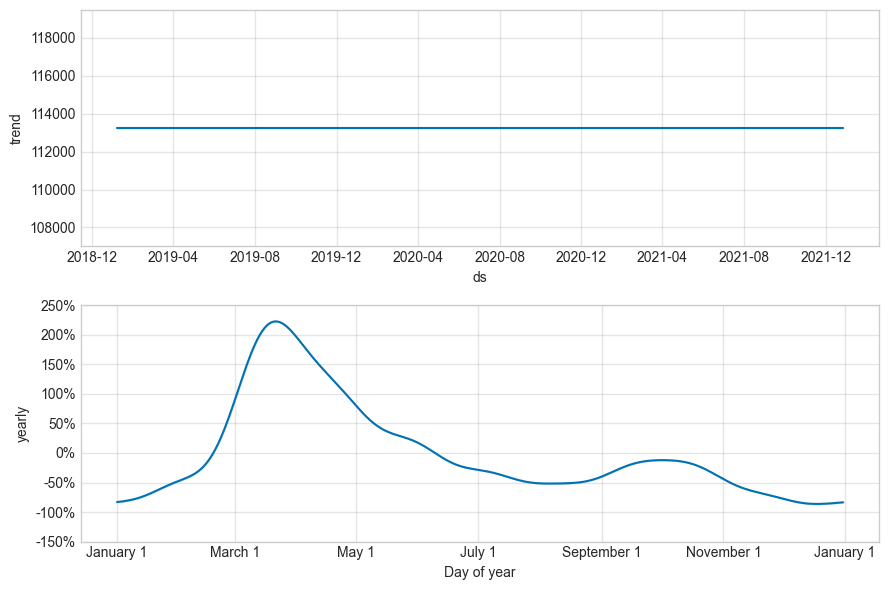

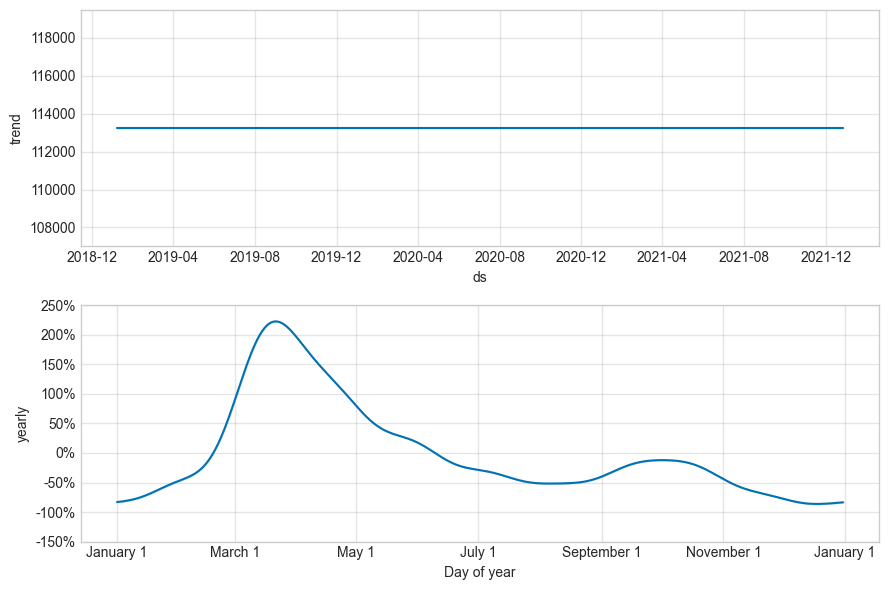

In [69]:
m.plot_components(df_predictions)

Text(0.5, 1.0, 'Residuals distribution (train set)')

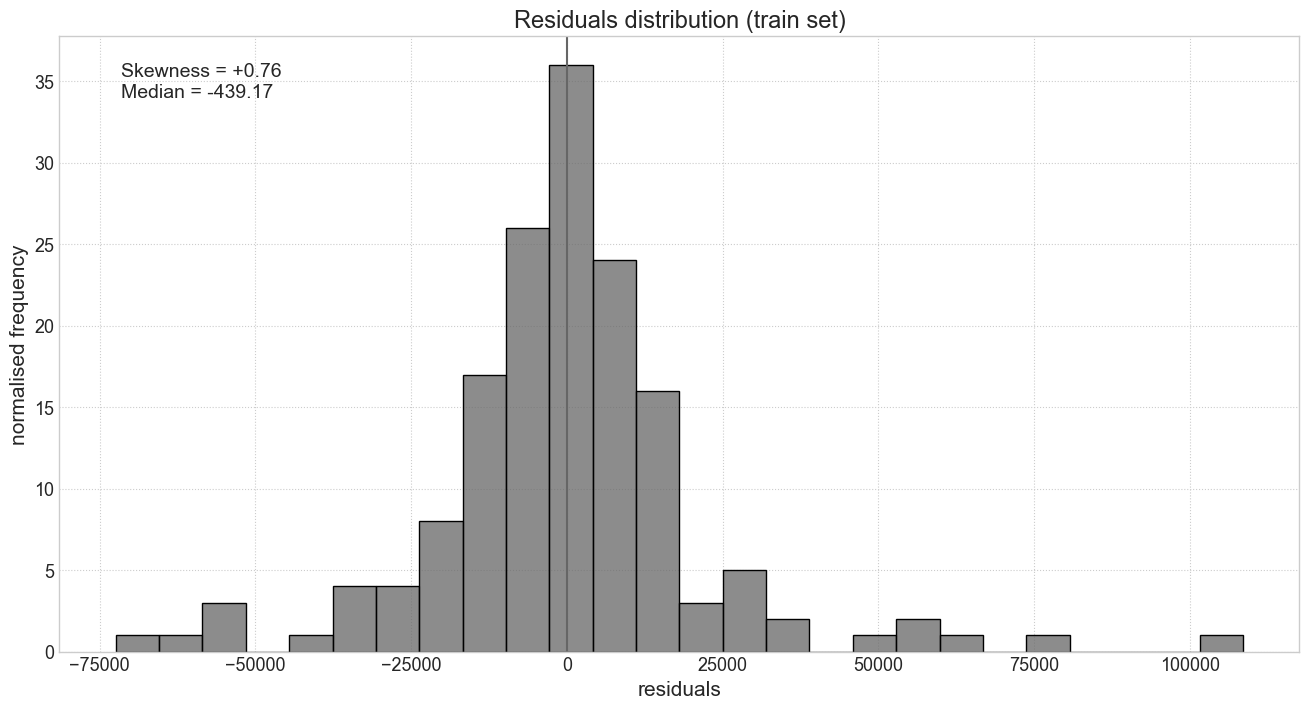

In [70]:
# plot residual histogram
f, ax = plt.subplots(figsize=(16,8))
sns.histplot((SOUTH_LF_TRAIN['y']- df_predictions['yhat']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(SOUTH_LF_TRAIN['y']- df_predictions['yhat']), (SOUTH_LF_TRAIN['y']- df_predictions['yhat']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (train set)', fontsize=17)

In [71]:
# correlation between actual and predicted values
SOUTH_LF_TRAIN['y'].corr(df_predictions['yhat'])

np.float64(0.9727103026225951)

The model with no external regressors seems to be performing pretty well. 
* The residual plot seems to be normal
* The predicted and acutal values seem to have a high degree of linear correlation

However, let's check the impact of external regressors on the overall prediction and residuals

In [72]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'growth' : ['linear', 'flat'],
    'seasonality_mode' : ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
mape = []

initial_period = '102 W'  
period_step = '30 W'     
forecast_horizon = '15 W' 

for params in all_params:
    m = Prophet(**params)
    m.add_regressor('AvgRelativeHumidityPercent')
    m.add_regressor('AvgSurfaceTemperatureFahrenheit')
    m.add_regressor('SumPrecipitationPreviousHourInches')
    m.add_regressor('AvgZeroToTenLiquidSoilMoisturePercent')
    m.fit(SOUTH_LF_TRAIN)
    df_cv = cross_validation(m, initial = initial_period, period = period_step, horizon = forecast_horizon, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mape.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mape

19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:36 - cmdstanpy - INFO - Chain [1] done processing
19:23:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:36 - cmdstanpy - INFO - Chain [1] done processing
19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing
19:23:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing
19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:40 - cmdstanpy - INFO - Chain [1] done processing
19:23:41 - cmdstanpy - INFO - Chain [1] start processing
19:23:41 - cmdstanpy - INFO - Chain [1] done processing
19:23:42 -

In [73]:
tuning_results.sort_values(by=['mape','rmse'])

,changepoint_prior_scale,seasonality_prior_scale,growth,seasonality_mode,rmse,mape
37,0.100,0.10,linear,multiplicative,42480.141601,0.264013
52,0.500,0.10,linear,additive,46326.025761,0.273922
60,0.500,10.00,linear,additive,45483.766572,0.278181
56,0.500,1.00,linear,additive,45524.213711,0.283163
53,0.500,0.10,linear,multiplicative,60344.258765,0.330410
...,...,...,...,...,...,...
1,0.001,0.01,linear,multiplicative,131681.569035,0.732920
49,0.500,0.01,linear,multiplicative,130271.243715,0.769564
48,0.500,0.01,linear,additive,132889.485138,1.345441
16,0.010,0.01,linear,additive,106507.000839,1.373558


In [74]:
# lets grab the best configration
best_param_grid = {  
    'changepoint_prior_scale': 0.100,
    'seasonality_prior_scale': 0.10,
    'growth' : 'linear',
    'seasonality_mode' : 'multiplicative'
}
m = Prophet(**params)
m.add_regressor('AvgRelativeHumidityPercent')
m.add_regressor('AvgSurfaceTemperatureFahrenheit')
m.add_regressor('SumPrecipitationPreviousHourInches')
m.add_regressor('AvgZeroToTenLiquidSoilMoisturePercent')    
m.fit(SOUTH_LF_TRAIN)
df_predictions = m.predict(SOUTH_LF_TRAIN)

19:27:34 - cmdstanpy - INFO - Chain [1] start processing
19:27:34 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
df_predictions[['AvgRelativeHumidityPercent_lower','AvgRelativeHumidityPercent_upper']]

,AvgRelativeHumidityPercent_lower,AvgRelativeHumidityPercent_upper
0,0.049494,0.049494
1,0.013565,0.013565
2,0.035663,0.035663
3,0.010408,0.010408
4,0.000035,0.000035
...,...,...
152,0.023035,0.023035
153,0.038369,0.038369
154,0.044683,0.044683
155,0.026192,0.026192


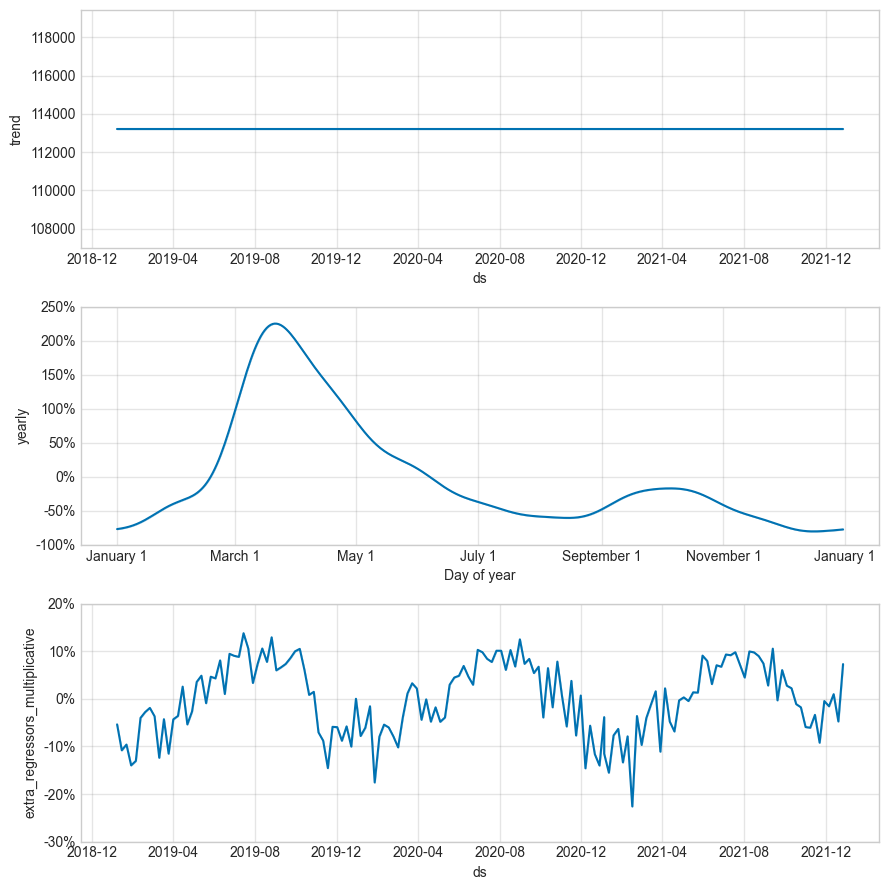

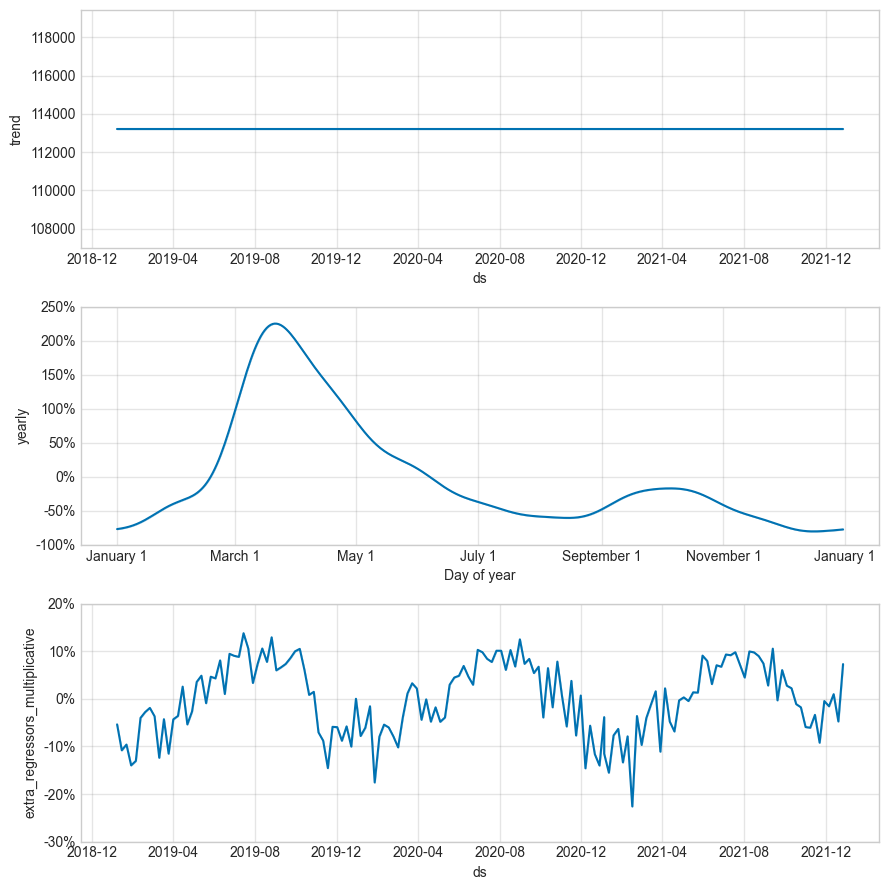

In [76]:
m.plot_components(df_predictions)

Text(0.5, 1.0, 'External Regressors (train set)')

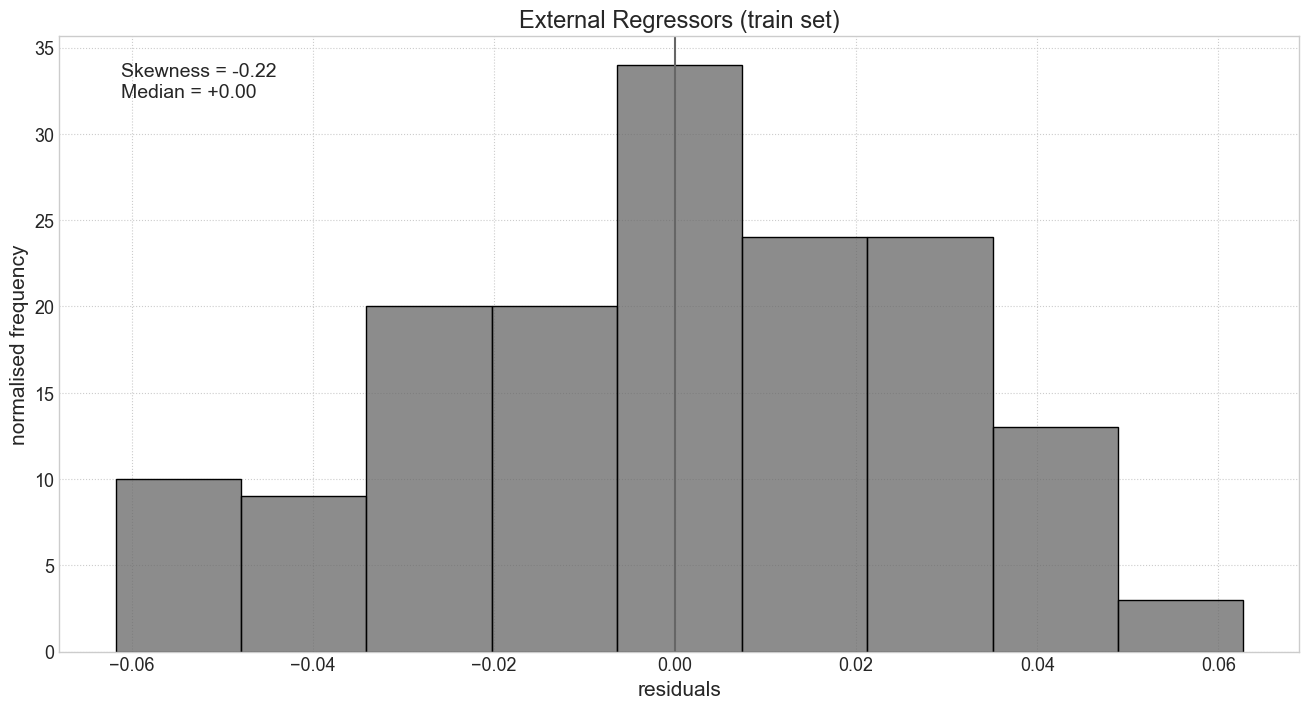

In [77]:
# plot residual histogram
f, ax = plt.subplots(figsize=(16,8))
sns.histplot(df_predictions['AvgRelativeHumidityPercent_lower'], ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(df_predictions['AvgRelativeHumidityPercent_lower']), (df_predictions['AvgRelativeHumidityPercent_lower']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('External Regressors (train set)', fontsize=17)

Text(0.5, 1.0, 'Residuals distribution (train set)')

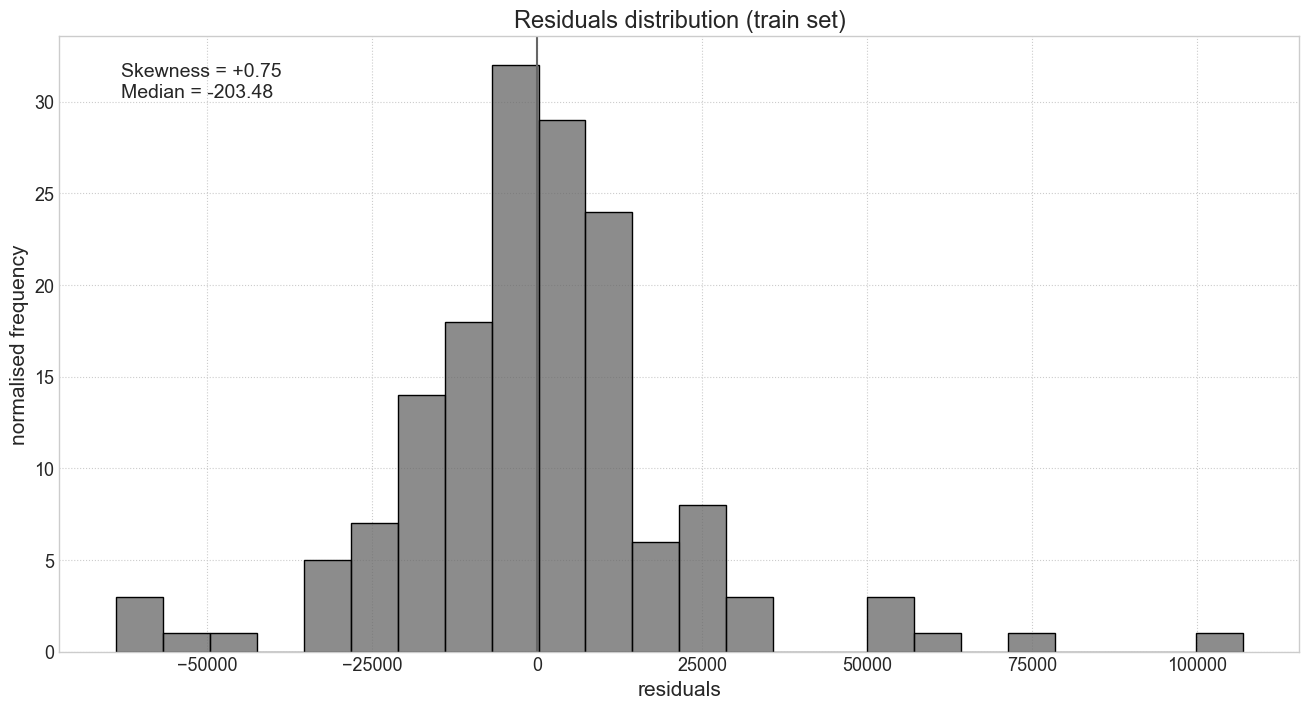

In [78]:
# plot residual histogram
f, ax = plt.subplots(figsize=(16,8))
sns.histplot((SOUTH_LF_TRAIN['y']- df_predictions['yhat']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(SOUTH_LF_TRAIN['y']- df_predictions['yhat']), (SOUTH_LF_TRAIN['y']- df_predictions['yhat']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (train set)', fontsize=17)

In [79]:
# correlation between actual and predicted values
SOUTH_LF_TRAIN['y'].corr(df_predictions['yhat'])

np.float64(0.9738312430912278)

Looking at the performance metrics like RMSE and MAPE and residual plots, we hardly see any explanation coming from the external regressors.

We also see that the seasonality component is highly dominant in explaining, hence we shall go ahead with the model without external regressors.

In [109]:
#test
SOUTH_LF_TEST

,Region,Category,Calendar year / week,Dollars,y,Week,Year,ds
0,SOUTH,LAWN FERTILIZERS,01/2022,820016.79,22971.0,01,2022,2022-01-03
1,SOUTH,LAWN FERTILIZERS,02/2022,758865.44,22772.0,02,2022,2022-01-10
2,SOUTH,LAWN FERTILIZERS,03/2022,618340.89,22276.0,03,2022,2022-01-17
3,SOUTH,LAWN FERTILIZERS,04/2022,660883.42,21790.0,04,2022,2022-01-24
4,SOUTH,LAWN FERTILIZERS,05/2022,991054.30,27740.0,05,2022,2022-01-31
5,SOUTH,LAWN FERTILIZERS,06/2022,1858330.18,49825.0,06,2022,2022-02-07
6,SOUTH,LAWN FERTILIZERS,07/2022,3125781.93,79169.0,07,2022,2022-02-14
7,SOUTH,LAWN FERTILIZERS,08/2022,4354528.03,106160.0,08,2022,2022-02-21
8,SOUTH,LAWN FERTILIZERS,09/2022,10372114.80,246894.0,09,2022,2022-02-28
9,SOUTH,LAWN FERTILIZERS,10/2022,7076973.85,169106.0,10,2022,2022-03-07


In [113]:
best_param_grid = {  
    'changepoint_prior_scale': 0.001,
    'seasonality_prior_scale': 10.0,
    'growth' : 'linear',
    'seasonality_mode' : 'multiplicative'
}
m = Prophet(**params)
m.fit(SOUTH_LF_TRAIN)
future = SOUTH_LF_TEST[['ds','y']]
forecast = m.predict(future)

20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing


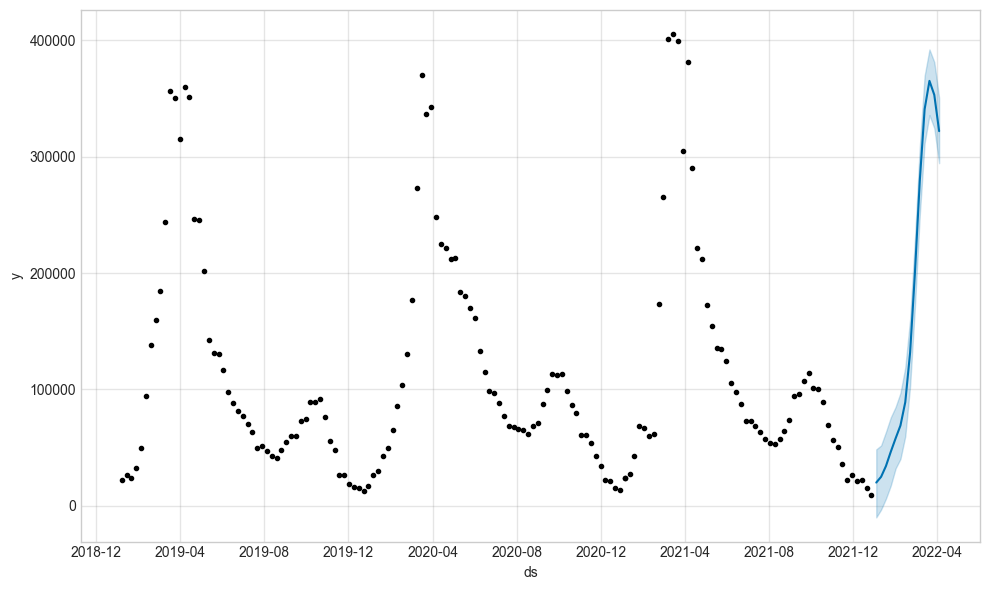

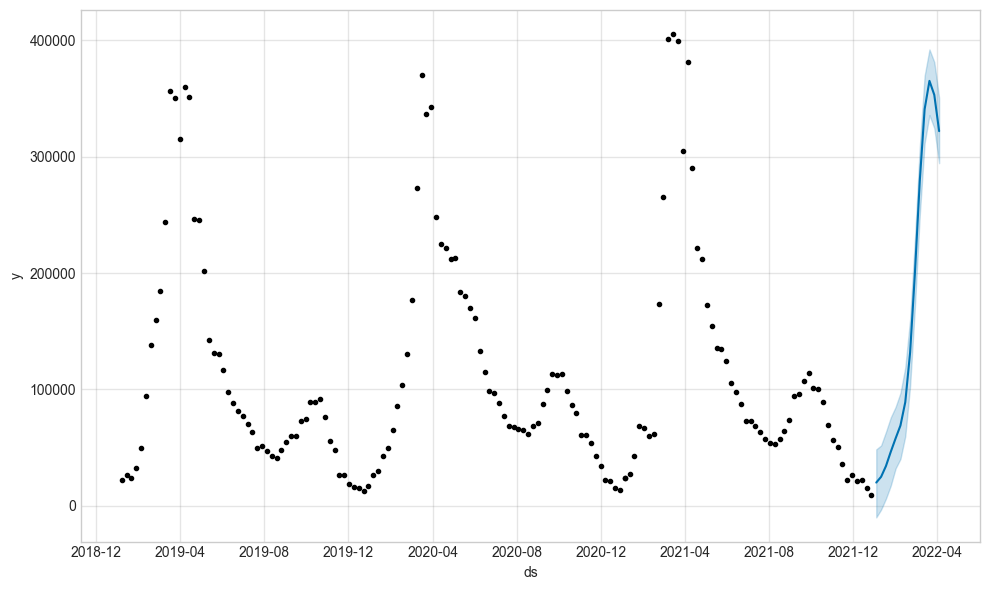

In [115]:
m.plot(forecast)

4. Generating comparison plot (Actual + Model 1 + Model 2 Forecasts)...


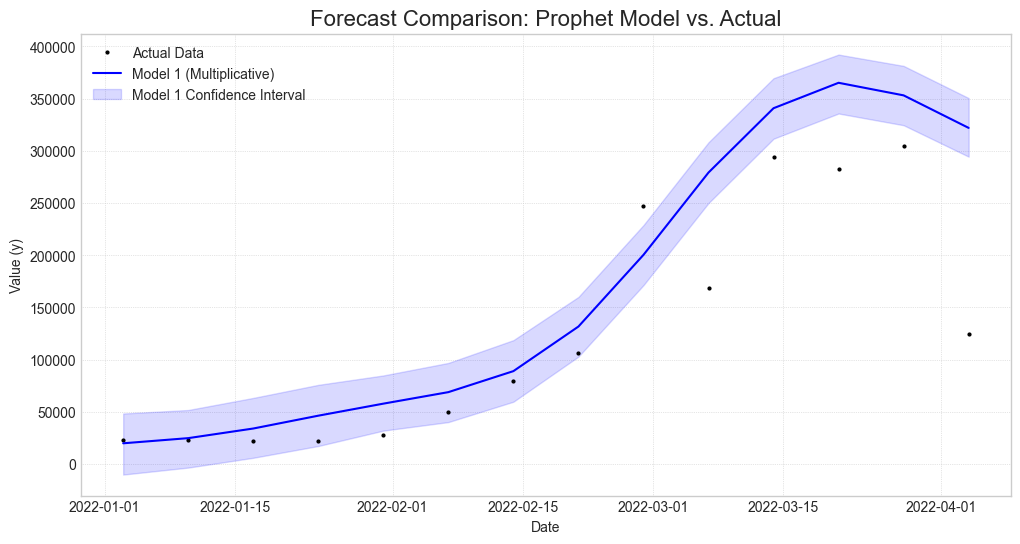

In [118]:
print("4. Generating comparison plot (Actual + Model 1 + Model 2 Forecasts)...")
rmse = np.sqrt(mean_squared_error(future['y'], historical_predictions['yhat']))
mape = mean_absolute_percentage_error(data['y'], historical_predictions['yhat'])

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(future['ds'], future['y'], 'k.', label='Actual Data', markersize=4)

ax.plot(forecast['ds'], forecast['yhat'], 
        label='Model 1 (Multiplicative)', color='blue', linestyle='-')

ax.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='blue', alpha=0.15, label='Model 1 Confidence Interval'
)

ax.text(
    0.02, 0.98, # Position in axes coordinates (top-left)
    annotation_text_mult, 
    transform=ax.transAxes, 
    verticalalignment='top', 
    fontsize=9, 
    bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5, 'edgecolor': 'blue'}
)

# Place Model 2 metrics annotation
ax.text(
    0.20, 0.98, # Position slightly right of Model 1
    annotation_text_add, 
    transform=ax.transAxes, 
    verticalalignment='top', 
    fontsize=9, 
    bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5, 'edgecolor': 'red'}
)


ax.set_title('Forecast Comparison: Prophet Model vs. Actual', fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Value (y)")
ax.grid(True, which='both', linestyle=':', linewidth=0.5)
ax.legend(loc='upper left')

plt.show()